In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

## Make Toy data

In [2]:
x_train = np.concatenate([np.random.randn(10000)*5 + 10, np.random.randn(10000)*5+20, np.random.randn(10000)*5 + 30])
y_train = np.array([0]*10000 + [1]*10000 + [2]*10000)

x_test = np.concatenate([np.random.randn(1000)*5 + 10, np.random.randn(1000)*5+20, np.random.randn(1000)*5 + 30])
y_test = np.array([0]*1000 + [1]*1000 + [2]*1000)

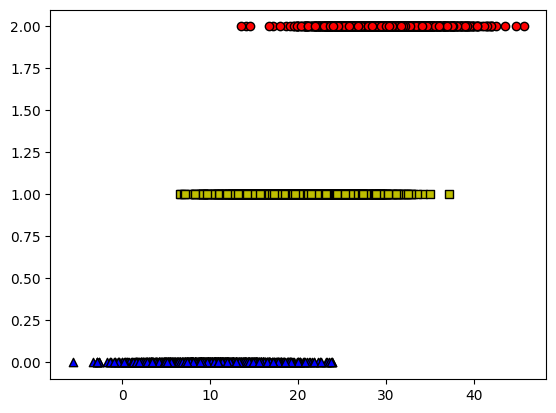

In [16]:
import matplotlib.pyplot as plt
plt.scatter(x_test[:1000], y_test[:1000], marker =  '^', color = 'b', edgecolors= 'k')
plt.scatter(x_test[1000:2000], y_test[1000:2000], marker =  's', color = 'y', edgecolors = 'k')
plt.scatter(x_test[2000:], y_test[2000:], marker =  'o', color = 'r', edgecolors = 'k')

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16).shuffle(1).cache().prefetch(1)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(1).cache().prefetch(1)

In [ ]:
x, y = next(iter(train_ds))
x.shape

TensorShape([16])

## Simple NN

In [17]:
model = keras.Sequential([
    keras.layers.Dense(10),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(3),
    keras.layers.Softmax()
])

model.build(input_shape = (1, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 10)                   20        
                                                                 
 activation (Activation)     (1, 10)                   0         
                                                                 
 dropout (Dropout)           (1, 10)                   0         
                                                                 
 dense_1 (Dense)             (1, 3)                    33        
                                                                 
 softmax (Softmax)           (1, 3)                    0         
                                                                 
Total params: 53 (212.00 Byte)
Trainable params: 53 (212.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.001, weight_decay = 0.8),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

model.fit(train_ds, validation_data = test_ds, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2669 - accuracy: 0.9487 - val_loss: 1.7139 - val_accuracy: 0.3333
Epoch 2/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.3480 - accuracy: 0.8940 - val_loss: 1.6979 - val_accuracy: 0.3333
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3896 - accuracy: 0.8692 - val_loss: 1.6929 - val_accuracy: 0.3333
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3844 - accuracy: 0.8693 - val_loss: 1.6852 - val_accuracy: 0.3333
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3848 - accuracy: 0.8689 - val_loss: 1.6838 - val_accuracy: 0.3333
Epoch 6/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3844 - accuracy: 0.8691 - val_loss: 1.6867 - val_accuracy: 0.3333
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3835 - accuracy: 0.8697 - val_loss: 1.6869 - val_accura

In [ ]:
model(np.array([50]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[101.98176]], dtype=float32)>

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_quant = converter.convert()

In [ ]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_test.astype(np.float32)).batch(1).take(100):
        # Model has only one input so each data point has one element
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant2 = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint 8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant3 = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [20]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [21]:
tflite_model_quant_file = tflite_models_dir/"lr.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

1652

In [ ]:
tflite_model_quant_file2 = tflite_models_dir/"lr_io32fp.tflite"
tflite_model_quant_file2.write_bytes(tflite_model_quant2)

2416

In [ ]:
# Save the using integer-only quantization:
tflite_model_quant_file3 = tflite_models_dir/"lr_io8int.tflite"
tflite_model_quant_file3.write_bytes(tflite_model_quant3)

2432

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global x_test

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path = str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices), ), dtype = int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = np.array([x_test[test_image_index]])
        # Check if the input type is quantized, the rescale input data to to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details['quantization']
            test_image = test_image/input_scale + input_zero_point
        test_image = np.expand_dims(test_image, axis = 0).astype(input_details['dtype'])
        interpreter.set_tensor(input_details['index'], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details['index'])[0]

        predictions[i] = output.argmax()

    return predictions

def evaluate_model(tflite_file, model_type):
  global x_test
  global y_test

  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(y_test== predictions) * 100) / len(y_test)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(y_test)))

In [ ]:
evaluate_model(tflite_model_quant_file, model_type="IO Float")

IO Float model accuracy is 75.0333% (Number of test samples=3000)


In [ ]:
evaluate_model(tflite_model_quant_file2, model_type="IO Float")

IO Float model accuracy is 74.7333% (Number of test samples=3000)


In [ ]:
evaluate_model(tflite_model_quant_file3, model_type="IO Float")

IO Float model accuracy is 43.8000% (Number of test samples=3000)


In [ ]:
interpreter = tf.lite.Interpreter(model_path = str(tflite_model_quant_file3))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
input_details

{'name': 'serving_default_dense_1_input:0',
 'index': 0,
 'shape': array([1, 1], dtype=int32),
 'shape_signature': array([-1,  1], dtype=int32),
 'dtype': numpy.uint8,
 'quantization': (0.09457956999540329, 19),
 'quantization_parameters': {'scales': array([0.09457957], dtype=float32),
  'zero_points': array([19], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [ ]:
import shutil
shutil.copy2(tflite_model_quant_file, '/content')
shutil.copy2(tflite_model_quant_file2, '/content')
shutil.copy2(tflite_model_quant_file3, '/content')

'/content/lr_io8int.tflite'

In [ ]:
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!xxd -i /content/lr.tflite > /content/cls_2h.cc
# Print the source file
!cat /content/cls_2h.cc

unsigned char _content_lr_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x90, 0x00, 0x00, 0x00, 0xe8, 0x00, 0x00, 0x00, 0xa8, 0x02, 0x00, 0x00,
  0xb8, 0x02, 0x00, 0x00, 0x0c, 0x07, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x98, 0xff, 0xff, 0xff, 0x07, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x73, 0x6f, 0x66, 0x74,
  0x6d, 0x61, 0x78, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,

In [ ]:
!xxd /content/sin_io32fp.tflite >> sin_io32fp.cc

In [ ]:
!echo "const unsigned char model[] = {" > /content/cls_io32fp.h
!cat /content/lr_io32fp.tflite | xxd -i      >> /content/cls_io32fp.h
!echo "};"                              >> /content/cls_io32fp.h

import os
model_h_size = os.path.getsize("/content/lr_io32fp.tflite")
print(f"Header file, /content/lr_io32fp.tflite, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, /content/lr_io32fp.tflite, is 1,608 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [ ]:
!echo "const unsigned char model[] = {" > /content/cls_io8int.h
!cat /content/lr_io8int.tflite | xxd -i      >> /content/cls_io8int.h
!echo "};"                              >> /content/cls_io8int.h

import os
model_h_size2 = os.path.getsize("/content/lr_io8int.tflite")
print(f"Header file, /content/lr_io8int.tflite, is {model_h_size2:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, /content/lr_io8int.tflite, is 1,616 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [ ]:
!echo "const unsigned char model[] = {" > /content/cls.h
!cat /content/lr.tflite | xxd -i      >> /content/cls.h
!echo "};"                              >> /content/cls.h

import os
model_h_size3 = os.path.getsize("/content/lr.tflite")
print(f"Header file, /content/lr.tflite, is {model_h_size3:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, /content/lr.tflite, is 1,108 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
